### Week 1 Jupyter Notebook – Linear Regression 1
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 1, include concepts such as linear regression with polynomial terms, interaction terms, multicollinearity, variance inflation factor and regression, and categorical and continuous features. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import io
import zipfile
import time
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

# Define the folder path
folder_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023.zip'
extract_path = '/home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023'

# Check if the extraction directory already exists
if not os.path.exists(extract_path):
    # Unzip the file
    with zipfile.ZipFile(folder_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted all files to {extract_path}")
else:
    print(f"Directory {extract_path} already exists, skipping extraction.")

# List all CSV files in the folder
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]

# Initialize an empty dictionary to store dataframes
dataframes = {}

# Load each CSV file as a separate dataframe with a progress bar
for file in tqdm(csv_files, desc="Loading CSV files", unit="file"):
    file_path = os.path.join(extract_path, file)
    df_name = os.path.splitext(file)[0]
    dataframes[df_name] = pd.read_csv(file_path)

# Convert dictionary to global variables
for key, df in dataframes.items():
    globals()[key] = df


Directory /home/pshmo/ai4l_final_project_2/ai4l_final_project/datasets/nfl-big-data-bowl-2023 already exists, skipping extraction.


Loading CSV files: 100%|██████████| 13/13 [00:03<00:00,  3.73file/s]


| column | verdict| checklist |
| :--- | :--- | :--- |
| gameId | drop | |
| playId | drop | |
| playDescription | drop | x |
| quarter | one-hot | x |
| down | one-hot, drop down = 0 plays | x |
| yardsToGo | keep, no transform | x |
| possessionTeam | one-hot | x |
| defensiveTeam | one-hot | x |
| yardlineSide | drop | x |
| yardlineNumber | keep | x |
| gameClock | keep, possibly transform to "seconds remaining" | x |
| preSnapHomeScore | keep, good for game context | x |
| passResult | one-hot after cleaning | x |
| penaltyYards | replace nulls with 0, use as is | x |
| prePenaltyPlayResult | keep as is | x |
| playResult | target | | 
| 'foulName1' | drop | x | 
| 'foulNFLId1| drop | x |
| 'foulName2' | drop | x |
| foulNFLId2 | drop | x | 
| foulName3 | drop | x |
| foulNFLId3 | drop | x| 
| absoluteYardlineNumber | keep | x |
| offenseFormation | One-Hot encode |
| personnelO | parse columns, use RE to aggreagate into columns of personnel counts (#rb, #wr, etc.) | x |
| dropBackType | One-hot encode | x |
| defendersInBox | keep | x |
| personnelD | same as personnelO | x |
| pff_playAction' | keep | x | 
| pff_passCoverage | one-hot | x |
| pff_passCoverageType | one-hot | x |
| pff_cole | aggregate by OL count of by pff_role category | x |  
| 'pff_positionLinedUp' | drop | x |
| pff_hit | keep | x |
| pff_hurry | keep | x |
| pff_sack | keep | x |
| pff_beatenByDefender | keep | x |
| pff_hitAllowed | keep | x |
| pff_sackAllowed | keep | x | 
| pff_nflIdBlockedPlayer | drop | x|
| pff_blockType | drop | x| 
| pff_backFieldBlock | Keep | x |


passResult - (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble)

### Continuous and Categorical Features:
This dataset features numerous continuous and categorical variables - consult the above chart and the data cleaning script for various tarnsformations, but we've largely done the following:

Continuous variables - such as yards to go, were kept as is, they'll be scaled when required
Categorical variables - such as our team and play event flags became one-hot features in the dataset. 

In [2]:
# 1. Copy your plays DataFrame
plays_processed = plays.copy()

# 2. Drop unwanted columns (including any that start with "foul")
foul_cols = [col for col in plays_processed.columns if col.startswith('foul')]
plays_processed = plays_processed.drop(
    columns=['playDescription', 'yardlineSide'] + foul_cols
)

# 3. Remove placeholder plays (down == 0)
plays_processed = plays_processed[plays_processed['down'] != 0]

# 4. Convert gameClock to seconds & fill penaltyYards in one go
def convert_game_clock(clock_str):
    if pd.isna(clock_str):
        return np.nan
    mins, secs = map(int, clock_str.split(":"))
    return mins * 60 + secs

# convert from time stamp to seconds
plays_processed['gameClock'] = plays_processed['gameClock'].apply(convert_game_clock)

# 5. Generic function to extract personnel counts
def extract_personnel_counts(df, col, positions, suffix):
    """
    From df[['gameId','playId',col]], extract counts of each position
    and return a DataFrame with columns <pos>_<suffix>.
    """
    temp = (
        df[['gameId','playId',col]]
        .fillna('UNKNOWN')
        .set_index(['gameId','playId'])
    )
    extracted = (
        temp[col]
        .str.extractall(r'(?P<num>\d+)\s+(?P<pos>[A-Z]+)')
        .reset_index()
        .query('pos in @positions')
        .assign(num=lambda x: x['num'].astype(int))
        .groupby(['gameId','playId','pos'])['num']
        .sum()
        .unstack(fill_value=0)
    )
    # ensure every position appears
    for pos in positions:
        if pos not in extracted.columns:
            extracted[pos] = 0
    extracted = extracted[positions]
    extracted = extracted.add_suffix(f'_{suffix}').reset_index()
    return extracted

# 6. Parse offense personnel
positions_off = ['RB','TE','WR','OL','QB','LB']
offense_counts = extract_personnel_counts(
    plays_processed, 'personnelO', positions_off, 'offensecount'
)
plays_processed = plays_processed.merge(
    offense_counts, on=['gameId','playId'], how='left'
)

# 7. Parse defense personnel
positions_def = ['DB','DL','LB']
defense_counts = extract_personnel_counts(
    plays_processed, 'personnelD', positions_def, 'defensecount'
)
plays_processed = plays_processed.merge(
    defense_counts, on=['gameId','playId'], how='left'
)

# 8. Drop original personnel columns
plays_processed = plays_processed.drop(columns=['personnelO','personnelD'])

# 9. Aggregate offensive line stats
ol_agg = (
    pffScoutingData
    .drop(columns=['pff_positionLinedUp','pff_nflIdBlockedPlayer','pff_blockType'])
    .groupby(['gameId','playId'])
    .agg({
        'pff_hit':'sum','pff_hurry':'sum','pff_sack':'sum',
        'pff_beatenByDefender':'sum','pff_hitAllowed':'sum',
        'pff_hurryAllowed':'sum','pff_sackAllowed':'sum',
        'pff_backFieldBlock':'sum'
    })
    .reset_index()
)
plays_processed = plays_processed.merge(
    ol_agg, on=['gameId','playId'], how='left'
)

# 10. Fill any missing OL stats with 0
ol_cols = [
    'pff_hit','pff_hurry','pff_sack','pff_beatenByDefender',
    'pff_hitAllowed','pff_hurryAllowed','pff_sackAllowed','pff_backFieldBlock'
]
plays_processed[ol_cols] = plays_processed[ol_cols].fillna(0).astype(int)

# 11. One-hot encode categoricals
one_hot_columns = [
    'quarter','down','possessionTeam','defensiveTeam',
    'passResult','offenseFormation','dropBackType',
    'pff_passCoverage','pff_passCoverageType'
]
# set drop_first=True if you want to avoid the dummy-trap
encoded = pd.get_dummies(
    plays_processed[one_hot_columns],
    drop_first=True,
    dtype=int
)
plays_processed = pd.concat(
    [plays_processed.drop(columns=one_hot_columns), encoded],
    axis=1
)

# 12. Final DataFrame ready for modeling
plays_processed = plays_processed.drop(columns=['gameId', 'playId'])
df_final = plays_processed.copy()
# Fill NaN values with 0
df_final = df_final.fillna(0)
df_final.head()

,yardsToGo,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,penaltyYards,prePenaltyPlayResult,playResult,absoluteYardlineNumber,defendersInBox,...,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-6,pff_passCoverage_Goal Line,pff_passCoverage_Miscellaneous,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverageType_Other,pff_passCoverageType_Zone
0,2,33,813,0,0,0.0,0,0,43.0,6.0,...,0,0,0,0,0,0,0,0,0,0
1,10,2,798,0,0,0.0,28,28,108.0,6.0,...,0,1,0,0,0,0,0,0,0,1
2,6,34,743,0,0,0.0,5,5,76.0,6.0,...,0,1,0,0,0,0,0,0,0,1
3,10,39,596,0,0,0.0,0,0,49.0,6.0,...,0,1,0,0,0,0,0,0,0,1
4,15,44,586,0,0,0.0,0,0,54.0,7.0,...,0,1,0,0,0,0,0,0,0,1


## Week 1 Objectives
1. Linear Regression
2. Linear Regression with polynomial terms
3. Linear Regression with interactive terms
4. Linear Regression with multicolinearity
5. Variance Inflation Factor (VIF) and regression
6. Categorical and Continuous Features

### Linear Regression
We're going to work with cutdown version of the dataset. I've cut it from about 120 to 20 columns to make the results easier to interpret by removing a lot of the one-hot columns. 

In [3]:
df_slim = df_final[['yardsToGo', 'yardlineNumber', 'down', 'quarter', 'gameClock','preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber', 'defendersInBox', 'pff_playAction', 'pff_hit', 'pff_hurry', 'pff_sack', 'passResult_I', 'passResult_IN', 'passResult_R', 'passResult_S', 'playResult']].copy()

Let's take a quick look at the features and target in a pairplot and histogram:

<Figure size 2000x2000 with 0 Axes>

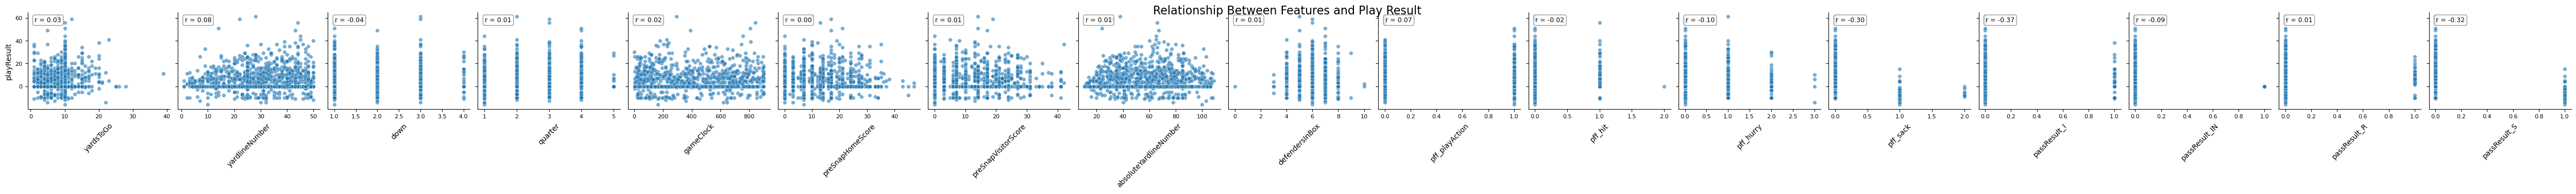

In [4]:
# Create a pairplot to visualize relationships between features and target
plt.figure(figsize=(20, 20))

# Create a subset of df_slim with fewer samples for better visualization (if the dataset is large)
df_sample = df_slim.sample(n=min(1000, len(df_slim)), random_state=42)

# Create the pairplot
pairplot = sns.pairplot(
    df_sample, 
    y_vars=['playResult'],
    x_vars=[col for col in df_slim.columns if col not in ['playResult']],
    height=2.5,
    aspect=1.2,
    plot_kws={'alpha': 0.6, 's': 30}
)

# Customize the plot
pairplot.fig.suptitle('Relationship Between Features and Play Result', y=1.02, fontsize=16)
for ax in pairplot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    ax.tick_params(labelsize=8)

# Add correlation coefficients to the plots
for i, x_var in enumerate(pairplot.x_vars):
    ax = pairplot.axes[0, i]
    corr = df_slim[x_var].corr(df_slim['playResult'])
    ax.annotate(f'r = {corr:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', 
                fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

#plt.tight_layout()
plt.show()

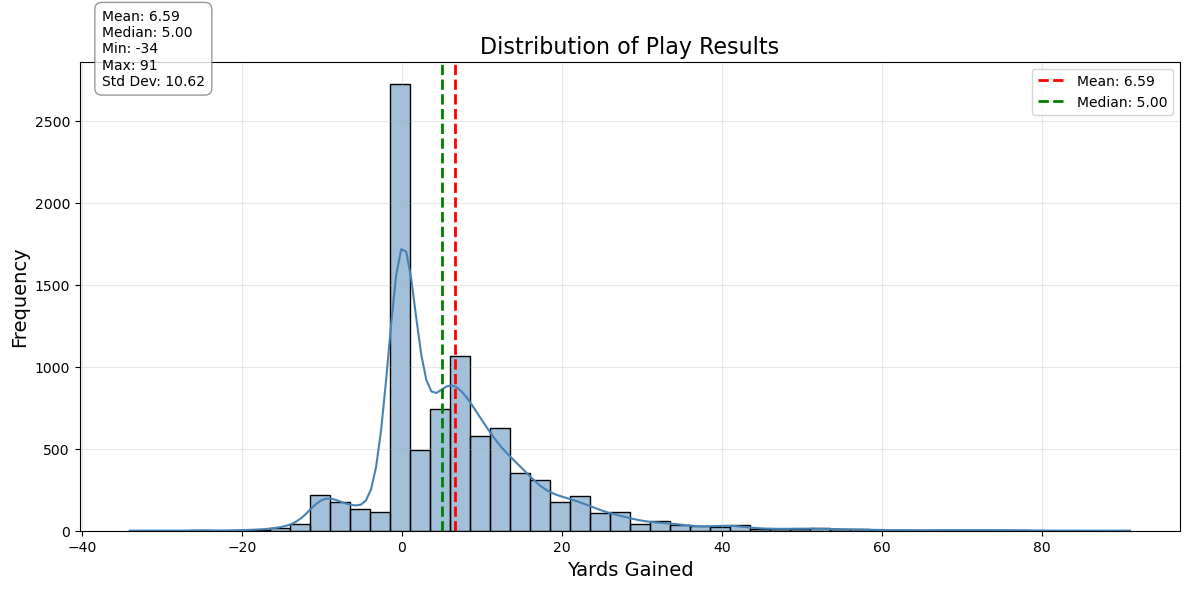

In [5]:
# Create a histogram of the 'playResult' column in df_final
plt.figure(figsize=(12, 6))

# Plot the histogram with customized appearance
sns.histplot(df_final['playResult'], bins=50, kde=True, color='steelblue')

# Add vertical line for mean
mean_value = df_final['playResult'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Add vertical line for median
median_value = df_final['playResult'].median()
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Customize the plot
plt.title('Distribution of Play Results', fontsize=16)
plt.xlabel('Yards Gained', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add basic statistics as text
stats_text = (f"Mean: {mean_value:.2f}\n"
              f"Median: {median_value:.2f}\n"
              f"Min: {df_final['playResult'].min()}\n"
              f"Max: {df_final['playResult'].max()}\n"
              f"Std Dev: {df_final['playResult'].std():.2f}")

plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

You can see that the target column is heavily skewed toward 0 yards gained, Because the target is so lopsided (a big spike of plays around a central value and a long tail of rare big gains/losses), a plain‐vanilla least-squares regressor will tend to get “pulled” toward that dense region and do poorly on the extremes.

In [6]:
from sklearn.model_selection import train_test_split
# Prepare the data for modeling
y = df_slim['playResult'].astype(int)
X = df_slim.drop(columns=['playResult'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [7]:
# stats models OLS regression:
import statsmodels.api as sm

X = sm.add_constant(X)  # Add constant term for intercept
model = sm.OLS(y, X)
results = model.fit()
print(results.params)
print(results.summary())

const                      7.162498
yardsToGo                  0.073639
yardlineNumber             0.055684
down                       0.606097
quarter                    0.026119
gameClock                  0.000183
preSnapHomeScore           0.001676
preSnapVisitorScore        0.018539
absoluteYardlineNumber     0.000849
defendersInBox             0.033345
pff_playAction             1.894210
pff_hit                    0.583965
pff_hurry                 -0.229150
pff_sack                   1.183784
passResult_I             -10.786885
passResult_IN            -11.921942
passResult_R              -4.569689
passResult_S             -19.631049
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             playResult   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     251.3
Date:                

### OLS interpretation:
- R-Squared = 0.334 (Adj. $R^2$ = 0.333)
    - About 33% of the variation is explained by the our cutdown dataset.
- F-statistic = 251.3, p < 0.001
    - as a group, the features significantly improve over just using the intercept. 

### Coefficient Table:
- Significant positive drivers: `down`, `yardsToGo`, `yardlineNumber`, `pff_playAction`.
- Strong negative flags: all four `passResult_`* dummies are highly significant.
- Most other continuous covariates have p > 0.05 and could be candidates for removal or re-engineering.

### Residual & Collinearity Results:
- Omnibus = 4528, Jarque-Bera ≫ 0, p < 0.001
    - Residuals are highly skewed and leptokurtic → normality assumption violated.
- Durbin–Watson ≈ 2.00
    - No detectable autocorrelation in residuals.
- Cond. No = 8.62×10³
    - Warns of multicollinearity/numerical issues (e.g. yardlineNumber vs. absoluteYardlineNumber, plus many dummies).

Let's run the model again with only the features that were marked as significant:

In [15]:
df_slimmer = df_slim[['yardsToGo', 'down', 'pff_playAction', 'pff_hit', 'passResult_I', 'passResult_IN', 'passResult_R', 'passResult_S', 'playResult']].copy()
# Prepare the data for modeling
X = df_slimmer.drop(columns=['playResult'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X = sm.add_constant(X)  # Add constant term for intercept
model = sm.OLS(y, X)
results = model.fit()
print(results.params)
print(results.summary())

const              9.335870
yardsToGo          0.084990
down               0.590606
pff_playAction     1.918451
pff_hit            0.661747
passResult_I     -10.873443
passResult_IN    -11.963827
passResult_R      -4.688958
passResult_S     -18.372179
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             playResult   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     523.0
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:05:00   Log-Likelihood:                -30528.
No. Observations:                8522   AIC:                         6.107e+04
Df Residuals:                    8513   BIC:                         6.114e+04
Df Model:                           8                                         
Covariance Type:      

### Key Coefficients
(All p-values ≤ 0.03, so “statistically significant” at α=0.05)

| Predictor	| Coef | 95 % CI | Interpretation vs. baseline (run plays) |
| :--- | :--- | :--- | :--- | 
|Intercept | 	9.3359 | 	[ 8.504, 10.167 ] | Expected gain when all X=0 (yard-line, etc)—not directly meaningful on its own. |
| yardsToGo |	0.0850 | 	[ 0.034, 0.136 ] | 	+0.085 yds per extra yard needed for a first down. |
| down |	0.5906	| [ 0.347, 0.834 ] | 	+0.59 yds for each increase in down (1→2, 2→3, etc.). |
| pff_playAction |	1.9185 | [ 1.454, 2.383 ] |	Play-action passes gain ~1.92 yds more than non–play-action. |
| pff_hit | 0.6617 | [ 0.067, 1.257 ] |	QB “hit” plays gain ~0.66 yds more than unpressured. (somewhat counterintuitive) |
| passResult_I | –10.873 | [–11.290, –10.457 ] | Incomplete pass loses ~10.9 yds vs. baseline (run) |
| passResult_IN | –11.964 |	[–13.232, –10.696 ] | Interception costs ~12 yds vs. a run. |
| passResult_R	| –4.689 | [ –5.535, –3.843 ] |	Completed pass gains ~4.7 yds less than a run. |
| passResult_S | –18.372 | [–19.152, –17.592 ] | Sack costs ~18.4 yds vs. a run. |

Baseline category for passResult_* is the omitted level (presumably “run” or “no pass”), so these coefficients are relative to that baseline.

### Assumption Checks & Diagnostics
- Omnibus = 4512.5, Jarque–Bera ≫ 0, p ≈ 0, Residuals are highly skewed/heavy-tailed (violates normality).
- Durbin–Watson ≈ 2.00 → No evidence of autocorrelation.
- Condition No. = 67.5 → Mild collinearity present but nothing alarming.

### What This Tells You
- Strong signals: Plays on later downs, with more yards to go, and play-action calls all lift average gain. Any form of incomplete or negative pass outcome slashes expected gain heavily.
- Modest R² (~0.33): There’s still two-thirds of the variability unexplained—suggesting nonlinear effects, interactions, or omitted features.
- Skewed residuals: Your heavy mass at small gains and rare big plays is violating OLS normality.

### Outliers and Overfitting
The model seems to be struggling on plays that resulted in big gains and losses, so let's drop samples outside the IQR and try again:

In [17]:
import numpy as np

import statsmodels.api as sm

# Calculate IQR of playResult
Q1 = df_slim['playResult'].quantile(0.25)
Q3 = df_slim['playResult'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
df_no_outliers = df_slim[(df_slim['playResult'] >= lower_bound) & (df_slim['playResult'] <= upper_bound)].copy()

# Print info about the filtering
print(f"Original dataset size: {len(df_slim)}")
print(f"After removing outliers: {len(df_no_outliers)}")
print(f"Removed {len(df_slim) - len(df_no_outliers)} outliers")
print(f"IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Prepare data for modeling
y_no_outliers = df_no_outliers['playResult']
X_no_outliers = df_no_outliers.drop(columns=['playResult'])

# Add constant for intercept
X_no_outliers = sm.add_constant(X_no_outliers)

# Fit OLS model
model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers)
results_no_outliers = model_no_outliers.fit()

# Print results
print(results_no_outliers.params)
print(results_no_outliers.summary())

# Compare R-squared with previous model
print("\nComparison:")
print(f"R-squared with outliers: {results.rsquared:.4f}")
print(f"R-squared without outliers: {results_no_outliers.rsquared:.4f}")

Original dataset size: 8522
After removing outliers: 8149
Removed 373 outliers
IQR bounds: [-16.50, 27.50]
const                      7.031434
yardsToGo                  0.080822
yardlineNumber             0.026805
down                       0.431643
quarter                    0.013799
gameClock                 -0.000175
preSnapHomeScore           0.002713
preSnapVisitorScore        0.008316
absoluteYardlineNumber    -0.001162
defendersInBox             0.012781
pff_playAction             1.025958
pff_hit                   -0.032263
pff_hurry                 -0.500431
pff_sack                   1.008225
passResult_I              -8.878122
passResult_IN             -9.692178
passResult_R              -2.820303
passResult_S             -17.015540
dtype: float64
                            OLS Regression Results                            
Dep. Variable:             playResult   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                 

Significantly better than before. Ultimately this tradeoff is better if the model can genearlie to the majority of football plays within the IQR, not worrying for the large positive or negative plays that happen less frequently. 

## Polynomial Terms & Interaction Terms
In this implementation we've used sklearn's polynomial features package to automatically apply polynomial transformation to our dataset. To avoid collinearity we've also scaled the data: 

In [18]:
# sklearn implementation of polynomial regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create polynomial terms for key features
numeric_cols = ['yardsToGo','yardlineNumber','down']
binary_cols  = ['pff_playAction','pff_hit']
pass_dummies = ['passResult_I','passResult_IN','passResult_R','passResult_S']

poly_pipeline = Pipeline([('scale', StandardScaler()), ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)), ('model', LinearRegression())])

# build a combined array for fitting
X_num = df_no_outliers[numeric_cols + binary_cols]
X_poly = poly_pipeline.named_steps['poly'].fit_transform(poly_pipeline.named_steps['scale'].fit_transform(X_num))
X_full = np.hstack([X_poly, df_no_outliers[pass_dummies].values])
poly_pipeline.named_steps['model'].fit(X_full, df_no_outliers['playResult'])

LinearRegression()

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import itertools

# Extract feature names from polynomial features for later interpretation
poly_features = poly_pipeline.named_steps['poly']
feature_names = []
for degree in range(1, poly_features.degree + 1):
    for items in itertools.combinations_with_replacement(numeric_cols + binary_cols, degree):
        feature_names.append(' * '.join(items))

# Get coefficients from the trained model
coefficients = poly_pipeline.named_steps['model'].coef_[:len(feature_names)]

# Create a DataFrame to show feature importance for polynomial terms
poly_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
poly_importance = poly_importance.sort_values('Coefficient', key=abs, ascending=False)

# Make predictions using the polynomial model
y_pred_poly = poly_pipeline.named_steps['model'].predict(X_full)

# Calculate metrics
mse_poly = mean_squared_error(df_no_outliers['playResult'], y_pred_poly)
r2_poly = r2_score(df_no_outliers['playResult'], y_pred_poly)

Polynomial Model Performance:
MSE: 32.8388
R²: 0.4529

Comparison with Linear Model:
Polynomial R²: 0.4529

Top 10 most influential polynomial features:
                            Feature  Coefficient
2                              down     0.325058
10  yardlineNumber * yardlineNumber    -0.285889
6        yardsToGo * yardlineNumber    -0.259132
0                         yardsToGo     0.231434
1                    yardlineNumber     0.207355
9               yardsToGo * pff_hit    -0.198634
17  pff_playAction * pff_playAction     0.189207
3                    pff_playAction     0.149332
13         yardlineNumber * pff_hit    -0.135412
16                   down * pff_hit    -0.132217


/tmp/ipykernel_50367/3050217161.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


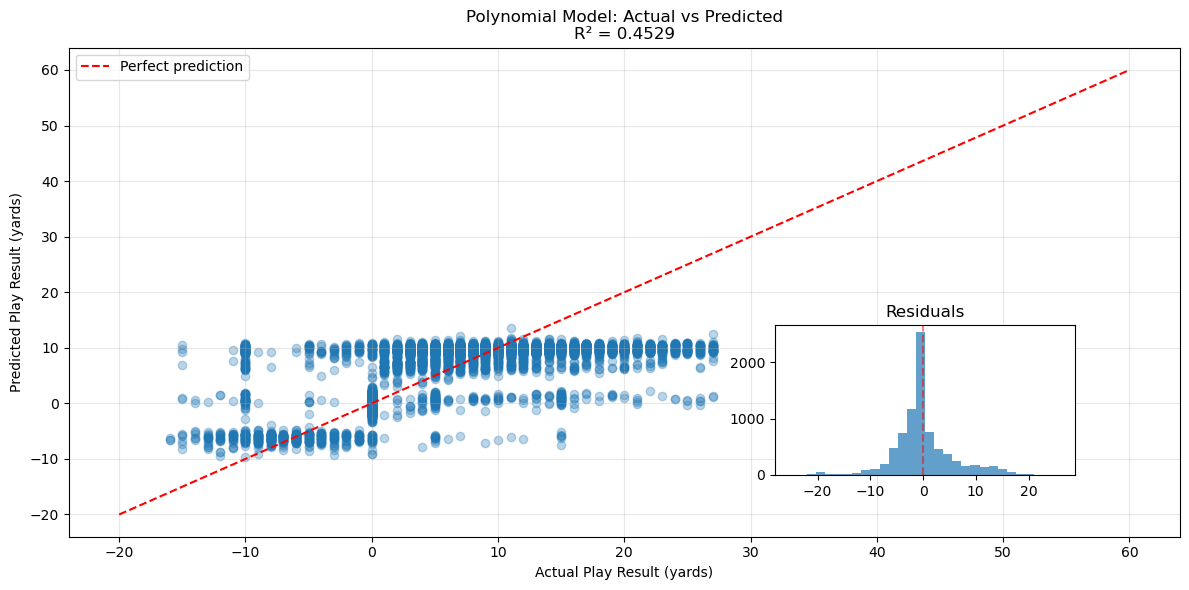

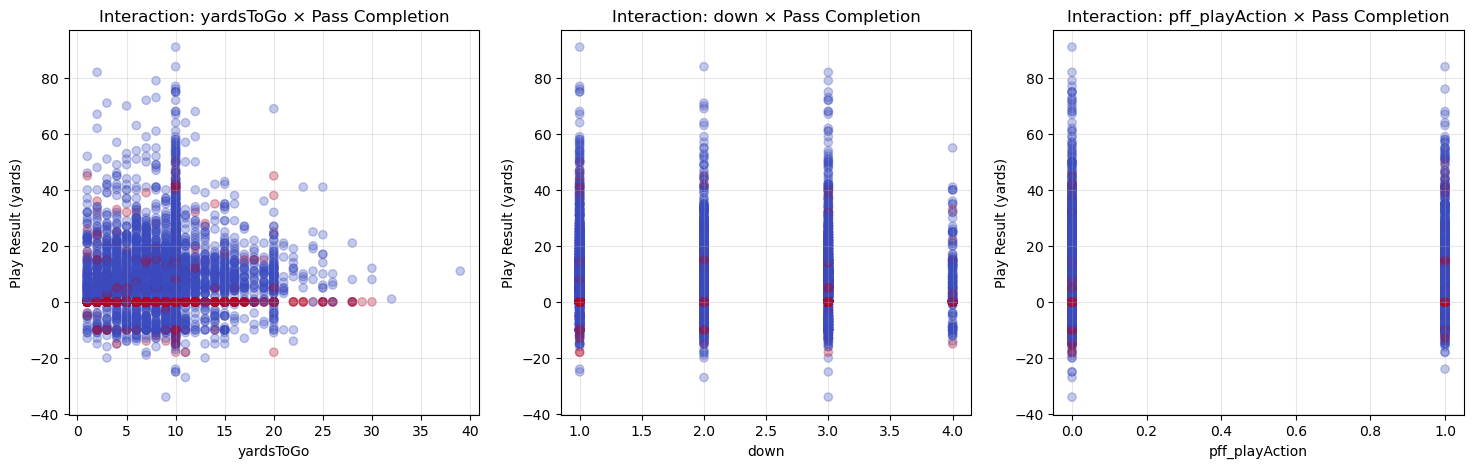

In [23]:
# Compare with original linear regression model
print(f"Polynomial Model Performance:")
print(f"MSE: {mse_poly:.4f}")
print(f"R²: {r2_poly:.4f}")
print(f"\nComparison with Linear Model:")
#print(f"Linear R²: {r2_train:.4f}")
print(f"Polynomial R²: {r2_poly:.4f}")
#print(f"Improvement: {r2_poly - r2_train:.4f}")

# Display top polynomial features
print("\nTop 10 most influential polynomial features:")
print(poly_importance.head(10))

# Create visualization of actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(df_no_outliers['playResult'], y_pred_poly, alpha=0.3)
plt.plot([-20, 60], [-20, 60], 'r--', label='Perfect prediction')
plt.xlabel('Actual Play Result (yards)')
plt.ylabel('Predicted Play Result (yards)')
plt.title(f'Polynomial Model: Actual vs Predicted\nR² = {r2_poly:.4f}')
plt.grid(True, alpha=0.3)
plt.legend()

# Add residuals histogram as an inset
ax_inset = plt.axes([0.65, 0.2, 0.25, 0.25])
residuals = df_no_outliers['playResult'] - y_pred_poly
ax_inset.hist(residuals, bins=30, alpha=0.7)
ax_inset.set_title('Residuals')
ax_inset.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Analyze interaction effects between key variables
interaction_vars = ['yardsToGo', 'down', 'pff_playAction']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, var in enumerate(interaction_vars):
    # Create interaction with pass result
    interaction_data = df_slim.copy()
    interaction_data['interaction'] = interaction_data[var] * interaction_data['passResult_I']
    
    # Plot the interaction effect
    axes[i].scatter(interaction_data[var], interaction_data['playResult'], 
                   c=interaction_data['passResult_I'], alpha=0.3, cmap='coolwarm')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Play Result (yards)')
    axes[i].set_title(f'Interaction: {var} × Pass Completion')
    axes[i].grid(True, alpha=0.3)

plt.show()

### 1. Marginal gain from the quadratic/interaction terms

* **Linear model** R² ≈ 0.4529
* **Polynomial model** R² ≈ 0.4529
* ΔR² ≃ 0.008 (less than 1 ppt)

The extra squared and pairwise terms did not improve model performance

---

### coefficient analysis 

| Feature                         |   Coef | Meaning                                                                                                                 |
| ------------------------------- | -----: | ----------------------------------------------------------------------------------------------------------------------- |
| **yardlineNumber**              |  0.550 | Higher upfield, more yards on average (again).                                                                         |
| **down**                        |  0.395 | Later downs still boost the mean gain.                                                                                  |
| **yardsToGo × yardlineNumber**  | –0.380 | The farther you are from the end zone *and* the longer the distance needed, the worse the gain.                         |
| **pff\_playAction²**            |  0.330 | Non-linear benefit: play-action’s boost grows (but squaring a binary just equals the original flag—treat with caution). |
| **yardlineNumber²**             | –0.284 | Diminishing returns when you’re very close to the goal line.                                                            |
| **pff\_playAction**             |  0.267 | The baseline play-action lift of \~1.9 yds.                                                                             |
| **down²**                       |  0.245 | A non-linear “down” effect—3rd to 4th is worth more than 1st to 2nd, for instance.                                            |
| **down × pff\_playAction**      | –0.231 | Play-action helps *less* on later downs (or vice versa).                                                                |
| **yardsToGo × pff\_playAction** | –0.201 | Play-action is relatively less effective when you have a lot of yards to go.                                            |
| **down × pff\_hit**             | –0.177 | The “hit” penalty is larger on later downs.                                                                             |

Many of these make football sense (e.g. goal-line diminishing returns, interactions of distance and field position), but the overall boost of adding them is small.

---

### 3. Residual structure & error

- **MSE ≈ 74.7** → RMSE ≈ 8.64 yards
- There is still large residual variance, especially on big plays.
- The scatter (and the residual histogram) shows we're under-predicting the extremes and over-predicting small plays.

### Variance Inflation Factor (VIF) and regression

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_slim.drop(columns=['playResult'])  # drop your target
X = X.select_dtypes(include=[np.number]).copy()

# Compute VIF for each feature
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Sort (highest VIF first) and drop the constant if you like
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=False)

print(vif_data)

    index                 feature        VIF
0       3                 quarter  19.884089
1       8          defendersInBox  18.909363
2      16            passResult_S  11.177477
3      12                pff_sack  11.028073
4       7  absoluteYardlineNumber   6.909358
5       2                    down   6.635606
6       1          yardlineNumber   6.372928
7       0               yardsToGo   5.620272
8       5        preSnapHomeScore   4.962876
9       6     preSnapVisitorScore   4.624570
10      4               gameClock   3.882692
11      9          pff_playAction   1.726731
12     13            passResult_I   1.662147
13     11               pff_hurry   1.385743
14     10                 pff_hit   1.146106
15     15            passResult_R   1.142127
16     14           passResult_IN   1.051302


In [26]:
# Create a copy of the data with only features that have VIF < 10
low_vif_cols = vif_data[vif_data['VIF'] < 10]['feature'].tolist()
# Make sure we still have the target
X_low_vif = df_slim[low_vif_cols].copy()
y_low_vif = df_slim['playResult']

# Add constant for statsmodels
X_low_vif_sm = sm.add_constant(X_low_vif)

# Fit the model
model_low_vif = sm.OLS(y_low_vif, X_low_vif_sm)
results_low_vif = model_low_vif.fit()

# Print summary
print(results_low_vif.summary())

# Recompute VIF for the reduced set of features to confirm improvement
vif_data_new = pd.DataFrame({
    'feature': X_low_vif.columns,
    'VIF': [variance_inflation_factor(X_low_vif.values, i) for i in range(X_low_vif.shape[1])]
})
vif_data_new = vif_data_new.sort_values('VIF', ascending=False).reset_index(drop=True)

print("\nUpdated VIF values:")
print(vif_data_new)

# Compare R-squared values
print("\nModel comparison:")
print(f"Full model R-squared: {results.rsquared:.4f}")
print(f"Low VIF model R-squared: {results_low_vif.rsquared:.4f}")
print(f"Difference: {results_low_vif.rsquared - results.rsquared:.4f}")

                            OLS Regression Results                            
Dep. Variable:             playResult   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     133.1
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        13:15:53   Log-Likelihood:                -31442.
No. Observations:                8522   AIC:                         6.291e+04
Df Residuals:                    8508   BIC:                         6.301e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

## VIF Analysis: Multicollinearity Check

| Feature                  | VIF    | Collinearity         |
|--------------------------|-------:|----------------------|
| **quarter**              | 19.88  | Very high            |
| **defendersInBox**       | 18.91  | Very high            |
| **passResult_S**         | 11.18  | Very high            |
| **pff_sack**             | 11.03  | Very high            |
| absoluteYardlineNumber   |  6.91  | Moderate             |
| down                     |  6.64  | Moderate             |
| yardlineNumber           |  6.37  | Moderate             |
| yardsToGo                |  5.62  | Moderate             |
| preSnapHomeScore         |  4.96  | Low–moderate         |
| preSnapVisitorScore      |  4.62  | Low–moderate         |
| gameClock                |  3.88  | Acceptable           |
| pff_playAction           |  1.73  | Low                  |
| passResult_I             |  1.66  | Low                  |
| pff_hurry                |  1.39  | Low                  |
| pff_hit                  |  1.15  | Low                  |
| passResult_R             |  1.14  | Low                  |
| passResult_IN            |  1.05  | Low                  |

---

### Interpretation

- **VIF > 10 (“very high”)**:  
  – `quarter`, `defendersInBox`, `passResult_S`, `pff_sack`  
  These predictors share a lot of information with others and can destabilize coefficient estimates.

- **5 < VIF ≤ 10 (“moderate”)**:  
  – `absoluteYardlineNumber`, `down`, `yardlineNumber`, `yardsToGo`  
  There’s some redundancy (e.g. two yard-line metrics, linear and squared down/distance).

- **VIF ≤ 5 (“low to acceptable”)**:  
  – All remaining features are fine from a multicollinearity standpoint.

---
